# 0. Setup: Installing LangChain and LangGraph

Run the two cells below to install the necessary dependencies and register your Groq API key:

In [ ]:
%%capture --no-stderr
#%pip install --no-cache-dir langchain_core langgraph langchain_groq
%pip install -U langchain-openai


In [ ]:
!pip install langchain langchain-experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00


In [ ]:
pip install -U langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.2 MB/s eta 0:00:00


In [ ]:
# code for groq key
"""
from getpass import getpass
import os
os.environ["GROQ_API_KEY"] = getpass("Provide your Groq API Key and hit 'Enter'")
"""

'\nfrom getpass import getpass\nimport os\nos.environ["GROQ_API_KEY"] = getpass("Provide your Groq API Key and hit \'Enter\'")\n'

In [ ]:
import pandas as pd
#from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
import openai

In [ ]:
# requirements.txt
%%writefile requirements.txt

<contents of your requiements.txt>

# 1. Loading the datasets
* TO-DO: make synthetic data using Chat-GPT

In [ ]:
# uncomment last two lines and run this cell to mount drive.
# make sure to save the student-2024-fall-ucal folder as a shortcut to your drive
#otherwise the file paths below will not work

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/student-2024-fall-ucal/Databases/

/content/drive/.shortcut-targets-by-id/1Rq001SFXrYKhYCSEjBlxgE_hNHlwMqi_/student-2024-fall-ucal/Databases


In [ ]:

import pandas as pd

cal_events = pd.read_csv('/content/drive/MyDrive/student-2024-fall-ucal/Databases/cal_events.csv')
cal_events.head(3)

,Start date-time,End date-time,Location Name,Location Address,Event title,Event description,Event tags,Target audience,Budget
0,10/11/2024 15:00:00,10/12/2024 16:00:00,Soda Hall Room 510,"2551 Hearst Ave, Berkeley, CA 94709",Data4All Undergraduate Teaching,DataCookies (October Edition): Data4All Underg...,"Data Science, Teaching, minority in EECS/Compu...","minority in EECS/Computer Science, junior tran...",0
1,10/12/2024 19:30:00,10/12/2024 22:30:00,Memorial Stadium,"210 Stadium Rim Way, Berkeley, CA 94720",8 Miami Hurricanes v California Golden Bears,Football Game,"College Sports, Football, School Spirit",Open to all,40
2,10/13/2024 13:00:00,10/13/2024 16:00:00,The Woz,"1860 Le Roy Ave, Berkeley, CA 94720",[HKN] Course Planning Workshop,Need help deciding what courses to take next s...,"Computer Science, Course planning, advising, c...","open to all, targeting CS/EECS majors",0


In [ ]:
user_persona = pd.read_csv('/content/drive/MyDrive/student-2024-fall-ucal/Databases/user_persona.csv')

In [ ]:
user_persona.head(2)

,UUID,Name,Username,School Year,Major,Event Preferences,Foodie Budget,Concert Budget,Free vs Paid Events,Preferred Day,Preferred Time of Day,Location Preference,Hobbies
0,1,Jane Doe,jane_doe,School Year,Data Science,"Foodies, Concerts",$15-30,$20-50,Occasional Paid,Weekends,Evenings,Walking distance,"Cooking, Art, Music Festivals"
1,2,John Smith,john_smith,Senior,Computer Science,"Concerts, Student Events",$30-50,$50-100,Mostly Free,Weekdays,Mornings,On-campus,"Sports, Movie Nights"


In [ ]:
# Converting the user persona CSV to json to better deal with variable types
# TO-DO: is it possible to store the user persona in json format from the login/signup page?
import csv

with open('/content/drive/MyDrive/student-2024-fall-ucal/Databases/user_persona.csv', 'r') as f:
    reader = csv.DictReader(f)
    json_user_data = list(reader)

import json

# Convert lists stored as strings back to actual lists
for item in json_user_data:
    item['Event Preferences'] = item['Event Preferences'].split(',')
    item['Hobbies'] = item['Hobbies'].split(',')
    if item.get('favoriteCuisines'):
        item['favoriteCuisines'] = item['favoriteCuisines'].split(',')
    if item.get('musicGenres'):
        item['musicGenres'] = item['musicGenres'].split(',')

# Optionally, write to a JSON file
with open('user_personas.json', 'w') as f:
    json.dump(json_user_data, f)

# 2. Loading the User Persona
*   TO-DO later: need to get the user persona from a database.
*   For now, we made up an example user persona to test our feedback agents


In [ ]:
# import necessary libraries for the user persona
from dataclasses import dataclass, field
from typing import List, Optional

In [ ]:
# Definition of the user persona class

@dataclass
class UserPersona:
    uuid: str
    name: str
    username: str
    schoolyear: int
    major: str
    event_preferences: List[str]  # Snake_case
    free_vs_paid_events: str
    preferred_day: str
    preferred_time_of_day: str
    location_preference: str
    hobbies: List[str]
    message_history: Optional[List[str]] = field(default = None)
    foodie_budget: Optional[str] = field(default = None)
    concert_budget: Optional[str] = field(default = None)
    favoriteCuisines: Optional[List[str]] = field(default = None)
    musicGenres: Optional[List[str]] = field(default=None)

    """
    other things to add in later
    password, gender, ethnicity, transfer, student_orgs
    message_history: List[str]
    """

In [ ]:
# Given someone's uuid, this function deserializes the json data and returns a user persona
def deserialize_user_persona(data):
    return UserPersona(
        uuid=data["UUID"],
        name=data["Name"],
        username=data["Username"],
        schoolyear=data["School Year"],
        major=data["Major"],
        event_preferences=data["Event Preferences"],
        foodie_budget=data.get("Foodie Budget"),
        concert_budget=data.get("Concert Budget"),
        free_vs_paid_events=data["Free vs Paid Events"],
        preferred_day=data["Preferred Day"],
        preferred_time_of_day=data["Preferred Time of Day"],
        location_preference=data["Location Preference"],
        hobbies=data["Hobbies"],
        message_history=data.get("message_history"),  # Use .get() for optional fields
        favoriteCuisines=data.get("favoriteCuisines"),
        musicGenres=data.get("musicGenres")
    )


In [ ]:
# Step 1: Locate Jane Doe's data
jane_doe_data = next((item for item in json_user_data if item['Name'] == 'Jane Doe'), None)

# Step 2: Deserialize Jane Doe's user persona
if jane_doe_data:
    jane_persona = deserialize_user_persona(jane_doe_data)
    # Now you can use 'jane_persona' as needed
    print(jane_persona)
else:
    print("Jane Doe not found in data")

UserPersona(uuid='1', name='Jane Doe', username='jane_doe', schoolyear='School Year', major='Data Science', event_preferences=['Foodies', ' Concerts'], free_vs_paid_events='Occasional Paid', preferred_day='Weekends', preferred_time_of_day='Evenings', location_preference='Walking distance', hobbies=['Cooking', ' Art', ' Music Festivals'], message_history=None, foodie_budget='$15-30', concert_budget='$20-50', favoriteCuisines=None, musicGenres=None)


# 3. Fetching all potential events for the User based on their calendar

Since working with gcal API is difficult, we will ask the user to input their availability for the next week beforehand

In [ ]:
from dataclasses import dataclass
from datetime import datetime, timedelta
import pandas as pd
from typing import List, Dict

@dataclass
class TimeWindow:
    start: datetime
    end: datetime

@dataclass
class CalendarAvailability:
    """Represents a user's calendar availability"""
    user_id: str
    free_windows: List[TimeWindow]

    @classmethod
    def from_calendar_data(cls, user_id: str, calendar_data: List[Dict[str, str]]):
        """
        Create availability from calendar data in format:
        [
            {
                "start": "2024-11-08 18:00:00",
                "end": "2024-11-09 00:00:00"
            },
            ...
        ]
        """
        windows = [
            TimeWindow(
                start=pd.to_datetime(slot["start"]),
                end=pd.to_datetime(slot["end"])
            )
            for slot in calendar_data
        ]
        return cls(user_id=user_id, free_windows=windows)

class CalendarMatcher:
    def __init__(self, events_df: pd.DataFrame):
        """
        Initialize with events database.
        """
        self.events_df = events_df

    def preprocess_events(self) -> pd.DataFrame:
        """Convert datetime strings to datetime objects."""
        events = self.events_df.copy()
        events['start_datetime'] = pd.to_datetime(events['Start date-time'])
        events['end_datetime'] = pd.to_datetime(events['End date-time'])
        return events

    def find_available_events(self, availability: CalendarAvailability, buffer_minutes: int = 30) -> List[Dict]:
        """
        Find events that fit within the user's available time windows.
        """
        events = self.preprocess_events()
        buffer = timedelta(minutes=buffer_minutes)
        matching_events = []

        for window in availability.free_windows:
            # Add buffer to window edges
            window_start = window.start + buffer
            window_end = window.end - buffer

            # Find events that fit within this window
            window_matches = events[
                (events['start_datetime'] >= window_start) &
                (events['end_datetime'] <= window_end)
            ]

            # Convert matching events to dict format
            for _, event in window_matches.iterrows():
                matching_events.append({
                    'title': event['Event title'],
                    'start': event['start_datetime'],
                    'end': event['end_datetime'],
                    'location': event['Location Name'],
                    'description': event['Event description'],
                    'location address': event['Location Address'],
                    'target_audience': event["Target audience"],
                    'budget': event['Budget']
                })

        return matching_events

# Example usage showing how to use with external data:
def demonstrate_matcher_with_data(events_df: pd.DataFrame, user_calendar_data: List[Dict[str, str]], user_id: str):
    """
    Demonstrate matcher using external calendar data.

    Args:
        events_df: DataFrame containing event information
        user_calendar_data: List of free time slots from user's calendar
        user_id: Identifier for the user
    """
    # Create availability from calendar data
    availability = CalendarAvailability.from_calendar_data(user_id, user_calendar_data)

    # Initialize matcher and find available events
    matcher = CalendarMatcher(events_df)
    available_events = matcher.find_available_events(availability)

    return available_events

In [ ]:
# Create some sample user availability for a busy student - from any calendar integration
sample_calendar_data = [
    {
        # Thursday evening
        "start": "2024-10-10 17:00:00",
        "end": "2024-10-10 22:00:00"
    },
    {
        # Friday afternoon/evening
        "start": "2024-10-11 14:00:00",
        "end": "2024-10-11 23:00:00"
    },
    {
        # Saturday whole day
        "start": "2024-10-12 10:00:00",
        "end": "2024-10-12 23:00:00"
    }
]

In [ ]:
# available all the time
sample_calendar_data1 = [
    {"start": "8/20/2021 23:00:00",
     "end": "10/20/2021 23:00:00",
    },
    {"start": "10/21/2021 09:00:00",
     "end": "11/20/2024 23:00:00",
    }
]

In [ ]:
# Initialize and run the matcher
availability = CalendarAvailability.from_calendar_data("student123", sample_calendar_data1)
matcher = CalendarMatcher(cal_events)
available_events = matcher.find_available_events(availability)

# Print results in a readable format
#print("Available events for your schedule:")
#for event in available_events:
#    print(f"\nEvent: {event['title']}")
#    print(f"Time: {event['start'].strftime('%A, %B %d at %I:%M %p')} - {event['end'].strftime('%I:%M %p')}")
#    print(f"Location: {event['location']}")
#    print("-" * 50)

In [ ]:
available_events

[{'title': 'Data4All Undergraduate Teaching',
  'start': Timestamp('2024-10-11 15:00:00'),
  'end': Timestamp('2024-10-12 16:00:00'),
  'location': 'Soda Hall Room 510',
  'description': 'DataCookies (October Edition): Data4All Undergraduate Teaching. Are you interested in undergraduate teaching? Do you identify as a minority in EECS/Computer Science and/or a junior transfer student? Join us on Friday October 11th (3-4pm)  for a panel on How to get involved in undergraduate teaching.\nWe invite students enrolled in computer systems classes (CS61C, CS162, CS186, CS161, CS152, CS168) to attend the next DataCookies event! Meet up with like minded students and find out more about what undergraduate teaching is like at Berkeley. You’ll hear from sophomores, juniors and seniors about when and how they got involved. It is never too early.\nThe event will take place in Soda 510. Refreshments will be provided.  There will be a period of mingling followed by a panel. The event is meant to be inf

In [ ]:
# Make an availableEvents dataclass

from pydantic import BaseModel, Field
from typing import Optional, List
from datetime import datetime

# Define EventData model
class EventData(BaseModel):
    title: str
    start: datetime
    end: datetime
    location: str
    description: str
    location_address: str = Field(..., alias="location address")
    target_audience: str
    budget: str

# 4. Dispatcher Agent that decides which worker agents to call for a given user persona
* Since we have many worker agents, not all of them may be necessary for making event recommendations.
* This reflection agent will decide which worker agents are relevant to call and call them
* Output: event recommendations from all the worker agents they decided to call
* TO-DO: code the dispatcher agent



In [ ]:
import regex as re

In [ ]:
# necessary classes for prompting

from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# necessary classes for having a state
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from langgraph.errors import GraphRecursionError


In [ ]:
!pip install --upgrade httpx
!pip install --upgrade --no-cache-dir "openai[httpx=0.27.2]"

ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/requirements.py", line 36, in __init__
    parsed = _parse_requirement(requirement_string)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/_parser.py", line 62, in parse_requirement
    return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/_parser.py", line 77, in _parse_requirement
    extras = _parse_extras(tokenizer)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/_parser.py", line 164, in _parse_extras
    with tokenizer.enclosing_tokens(
  File "/usr/lib/python3.10/contextlib.py", line 142, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/_tokenizer.py", line 189, in enclosing_tokens
    self.raise_syntax_error(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/_tok

In [ ]:
# initialize the open AI LLM that the worker agents will use
llm = ChatOpenAI(
    model="gpt-4o", # The name of the language model to use
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key = OPENAI_API_KEY
)

TypeError: Client.__init__() got an unexpected keyword argument 'proxies'

In [ ]:
# initialize the Groq LLM that the worker agents will use
"""
llm = ChatGroq(
    model="llama3-70b-8192", # The name of the language model to use
    temperature=0.0, # Controls how deterministic the LLM is in choosing the next token
    timeout=None, # How long should a request wait for a resonse
    max_retries=2 # How many times should we retry a request
)
"""

In [ ]:
from typing import Annotated, Sequence
from typing import TypedDict
import operator
from typing_extensions import Literal

In [ ]:
# new class state

class State(TypedDict):
    user_persona: UserPersona
    agentsToInvoke: List[str]
    available_events: List[EventData]
    feedback: Optional[str]
    eventRecommendations: Annotated[list, operator.add]
    messageHistory: Annotated[list, operator.add]
    current_draft: int
    feedback: Optional[str]
    grade: Optional[int]
    #threshold: int = 95
    #max_drafts: int = 3
    #current_draft: int = 0

In [ ]:
tempState = State(user_persona=jane_persona, agentsToInvoke=[], available_events=available_events,
      messageHistory=[], eventRecommendations=[])

In [ ]:
tempState["messageHistory"].append("hi")
tempState["messageHistory"]

In [ ]:
tempState["eventRecommendations"].append("foo")

In [ ]:
tempState["eventRecommendations"]

In [ ]:
# global list of all worker agents
workerAgentsList = ["foodie", "concerts"]
workerAgentsList

In [ ]:
dispatcherAgent_prompt = """
    You oversee a team of event recommender agents who each specialize in recommending specific types of events.

    Your job is to decide which event recommenders to activate for a certain User Persona

    Rules:
    - You can ONLY output event recommenderes that are in the ListOfEventRecommenders

    You must generate a response in the following List format:
    [agent1name, agent2name, agent3name, ....]
"""

dispatcher_prompt_template = ChatPromptTemplate.from_messages([
    ("system", dispatcherAgent_prompt),
    ("human", "User Persona:\n{UserPersona}\n\n ListOfEventRecommenders:\n{workerAgentsList}")
])

In [ ]:
dispatcher_agent = (dispatcher_prompt_template | llm)

In [ ]:
# test out the dispatcher chain
prompt = dict(UserPersona = jane_persona,
              workerAgentsList = workerAgentsList)
dispatcher_agent_response = dispatcher_agent.invoke(prompt)
print(dispatcher_agent_response.content)

In [ ]:
type(dispatcher_agent_response.content)

In [ ]:
import ast

In [ ]:
actual_list = ast.literal_eval(dispatcher_agent_response.content)

print(actual_list)  # Output: ['foodie', 'concerts']
print(type(actual_list))  # Output: <class 'list'>

In [ ]:
import ast
def dispatcherAgentNode(state: State, config: RunnableConfig) -> State:
  """
  This node is responsible for taking in a user persona and invoking the propert worker agents
  """

  agent = config["configurable"]["agents"]["dispatcher"]
  prompt = dict(
      UserPersona = state.get("user_persona"),
      workerAgentsList = workerAgentsList # this is a global variable
  )
  # invoke the agent to decide which worker agents to activate
  response = agent.invoke(prompt)
  print(response.content) # this is the list of agents to invoke
  state["agentsToInvoke"] = ast.literal_eval(response.content)
  state["current_draft"] = 0
  #print("input into agentsToInokve: ", response.content)
  #print("state agents to invoke: ", state.get("agentsToInvoke"))


  return state

# 5. Initalize many worker events that make specific event recommendations
* right now we only have food and concerts
* TO-DO: make more worker agents
* active, crafty, flim, reading, activism, volunteering,

In [ ]:
# make a global variable for the userPersona throughout the chain since it doesn't change anyways
userPersonaCurr = jane_persona

### 4.1: Food worker agent

In [ ]:
# defined a foodie agent prompt
foodie_agent_prompt = """
You are an expert in the foodie and culinary scene of Berkeley, California, and the surrounding Bay Area (including San Francisco, Oakland, Emeryville, San Jose, and Cupertino).

Rules:
- Think through your feedback and recommendations step by step

User Profile:
- favoriteCuisines: {favoriteCuisines}
- Budget Range: {foodie_budget}
Event Data: {event_data}


Guidelines for Recommendations:

Relevance: Choose events that align with the user's preferences and budget range, unless an event is exceptionally relevant in other ways.
Diversity: Aim to recommend a variety of food experiences or events, such as tastings, grand openings, or cultural food festivals.
Budget: Ensure most recommendations fit within the user’s budget. If an event has no cost information, recommend it if it aligns with the user's preferences.

Output:
Provide three recommended events as described.
"""

foodie_agent_prompt_templae = ChatPromptTemplate.from_messages([
    ("system", foodie_agent_prompt),
    ("human", "favoriteCuisines:\n{favoriteCuisines}\n\nfoodie_budget:\n{foodie_budget}\n\nevent_data:{event_data}")
    ])

foodie_agent = (foodie_agent_prompt_templae | llm)

In [ ]:
def foodieNode(state: State, config: RunnableConfig):
  """
  This node is responsible for taking in events and fields from a userPersona to generate specific event recommendations for food
  """
  agent = config["configurable"]["agents"]["foodie"]

  userPersona = state.get("user_persona")
  prompt = dict(
      favoriteCuisines = userPersona.favoriteCuisines,
      foodie_budget = userPersona.foodie_budget,
      event_data = state.get("available_events"),
  )
  response = agent.invoke(prompt)
  print("food node recommendations: ", response.content)
  #state["eventRecommendations"].append(response.content)
  print("foodie node event recommendations: ", state.get("eventRecommendations"))

  print("foodie node state: ", state)
  return {"eventRecommendations": [response.content]}

### 4.2: Concert worker agent

In [ ]:
concerts_agent_prompt = """
    You are a music events expert for the Bay Area, specializing in personalized recommendations.

    Rules:
    - Think through your feedback and recommendations step by step

    User Profile:
    Music Genres: {musicGenres}
    Budget Range: {budget_range}

    Event Data: {event_data}


    Guidelines for Recommendations:
    Genre Alignment: Prioritize events that match the user’s preferred genres. If no exact genre matches are available, recommend events that would likely appeal to the user based on their demographic information (e.g., age, gender).
    Budget Consideration: Ensure that most events fit within the user’s budget. If budget data is missing for an event, still consider it if it strongly aligns with the user’s musical interests.
    Diversity: Include a mix of events, such as live performances, festivals, or intimate acoustic sessions, to enrich the user’s music experience.

    Output:
    Provide three recommended events as described.

"""

concert_agent_prompt_template = ChatPromptTemplate.from_messages([
    ("system", concerts_agent_prompt),
    ("human", "musicGenres:\n{musicGenres}\n\budget_range:\n{budget_range}\n\nevent_data:{event_data}")
    ])

concert_agent = (concert_agent_prompt_template | llm)

In [ ]:

def concertNode(state: State, config: RunnableConfig):
  """
  This node is responsible for taking in events and fields from a userPersona to generate specific event recommendations for food
  """

  agent = config["configurable"]["agents"]["concerts"]
  userPersona = state.get("user_persona")
  prompt = dict(
      musicGenres = userPersona.musicGenres,
      budget_range = userPersona.concert_budget,
      event_data = state.get("available_events"),
  )
  response = agent.invoke(prompt)
  print("concert Nodes recs: ", response.content)
  #state.get("eventRecommendations").append(response.content)

  print("append to message history and event Recommendations")
  print("concert node event recommendations: ", state.get("eventRecommendations"))

  print("concert node state: ", state)
  return {"eventRecommendations": [response.content]}

# Curator Agent
* This agent takes in all recommended events from the worker events and decides which to recommend to the user
* These decisions are based on the user profile and some hard constraints of the user

In [ ]:
curatorAgent_prompt = """
    You take in event recommendations from many different event specialist (foodie, concerts, crafts, etc).
    Your job is to decide which events to recommend to the user.

    Rules:
    - Recommend only the top 3 events that the user will most enjoy
    - The user must be the target audience for these events. If the user is not the target audience, it will make them uncomfortable
    - Recommend events that the user would enjoy the most based on their user profile

    User Profile:
    {UserPersona}

    Event Recommendations:
    {eventRecommendations}

    Feedback:
    {feedback}

"""

curator_prompt_template = ChatPromptTemplate.from_messages([
    ("system", curatorAgent_prompt),
    ("human", "User Persona:\n{UserPersona}\nEvent Recommendations:\n{eventRecommendations}\nfeedback:\n{Feedback}")
])

In [ ]:
curator_agent = (curator_prompt_template | llm)

In [ ]:
def curatorNode(state: State, config: RunnableConfig) -> State:
  """
  This node is responsible for taking in event recommendations and then making final event recommendations based on the user persona
  """

  agent = config["configurable"]["agents"]["curator"]
  print("in curator Node")
  prompt = dict(
      UserPersona = state.get("user_persona"),
      eventRecommendations = state.get("eventRecommendations"),
      feedback = state.get("feedback")
  )
  response = agent.invoke(prompt)
  print("curator agent response: ", response.content)
  state.get("messageHistory").append(response.content)
  state["current_draft"] += 1
  print("curator recommendations: ", response.content)
  return state

# Curator Feedback Agent
This node gives feedback to the curator agent

In [ ]:
from pydantic import BaseModel, Field

In [ ]:
class ReflectionState(BaseModel):
  grade: int = Field(description="The grade of the event recommendations out of 5, with 5 being a perfect score")

In [ ]:
curatorFeedback_prompt = """ You are a seasoned events recommender who is able to curate events for people based on their interests.
Your goal is to give feedback to the curator agent to ensure that the best events are getting recommended for the user out of all the available events

You must generate a response in the following JSON format:
{{
  "feedback": "Your feedback to the curator agent on what went well, what didn't, and how they can improve the event recommendations.",
  "grade": "The grade of the event recommendations out of 5, with 5 being a perfect score"
}}

Think things through step-by-step
"""

curatorFeedback_prompt_template = ChatPromptTemplate.from_messages([
    ("system", curatorFeedback_prompt),
    ("human", "User Persona:\n{UserPersona}\nEvent Recommendations:\n{eventRecommendations}\nCurator Agent recommendations:\n{messageHistory}")
])

In [ ]:
curatorFeedback_chain = (curatorFeedback_prompt_template | llm)

In [ ]:
def curatorFeedback(state: State, config: RunnableConfig) -> State:
  """This node is responsible for critiquing the output of the curator node and providing constructive feedback
  """
  print("At the editor node")
  agent = config["configurable"]["agents"]["curatorFeedback"]
  prompt = dict(
      UserPersona = state.get("user_persona"),
      eventRecommendations = state.get("eventRecommendations"),
      messageHistory = state.get("messageHistory")
  )
  response = agent.invoke(prompt)
  state.feedback = response.feedback
  state.grade = response.grade
  print("this is the feedback: ", state.feedback)
  print("this is the grade: ", state.grade)
  return state

# Events Writer Agent
This event takes in the final events recommendations and packages them into an exciting manner for the user

In [ ]:
eventsWriter_prompt = """
    You take in event recommendations from the curator Agent (which is inside the messageHistory) and write them in an exciting manner to the user to take in.

    Rules:
    - Must include the date and time of each event
    - Include a short description of why the event would be exciting to the user and what the event is about

    User Profile:
    {UserPersona}

    Final Event Recommendations:
    {messageHistory}

"""

eventsWriter_prompt_template = ChatPromptTemplate.from_messages([
    ("system", eventsWriter_prompt),
    ("human", "User Persona:\n{UserPersona}\nFinal Event Recommendations:\n{messageHistory}")
])

In [ ]:
eventsWriter_agent = (eventsWriter_prompt_template | llm)

In [ ]:
def eventsWriterNode(state: State, config: RunnableConfig) -> State:
  """
  This node is responsible for taking in event recommendations and then making final event recommendations based on the user persona
  """
  agent = config["configurable"]["agents"]["eventsWriter"]
  prompt = dict(
      UserPersona = state.get("user_persona"),
      messageHistory = state.get("messageHistory")
  )
  response = agent.invoke(prompt)
  state.get("messageHistory").append(response.content)
  print("Final Event recommendations: ", response.content)
  return state

In [ ]:
curator_agent = (curator_prompt_template | llm)

# 7. Putting the graph together

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
# Add the nodes
graph_builder.add_node("dispatcher", dispatcherAgentNode)
graph_builder.add_node("foodie", foodieNode)
graph_builder.add_node("concerts", concertNode)
#graph_builder.add_node("merger", mergerNode)
graph_builder.add_node("curator", curatorNode)
graph_builder.add_node("eventsWriter", eventsWriterNode)


In [ ]:
graph_builder.set_entry_point("dispatcher")

In [ ]:
def activate_nodes(state: State) -> Sequence[str]:
  if state.get("agentsToInvoke") is None:
    return END
  else:
    return state.get("agentsToInvoke")

workerAgents = ["foodie", "concerts"]

In [ ]:
graph_builder.add_conditional_edges("dispatcher", activate_nodes, workerAgents)

for node in workerAgents:
  graph_builder.add_edge(node, "curator")

In [ ]:
def rewrite_or_submit(state: State) -> Literal["eventsWriter", END]:
  if state.grade >= 95 or state.current_draft >= 3:
    print(state.draft)
    return END
  else:
    return "eventsWriter"

In [ ]:
graph_builder.add_edge("curator", "curatorFeedback")
graph_builder.add_edge("curatorFeedback", rewrite_or_submit)
graph_builder.add_edge("curatorFeedback", "eventsWriter")
graph_builder.add_edge("eventsWriter", END)

In [ ]:
graph_config = {
    "configurable": {
        # You can add items to pass into your nodes using this config.
        # This is a preferred method of injecting dependencies into your
        # node functions
        "agents": {
            "dispatcher": dispatcher_agent,
            "foodie": foodie_agent,
            "concerts": concert_agent,
            "curator": curator_agent,
            "eventsWriter": eventsWriter_agent
        },
        # The thread_id is used to help persist the state across sessions.
        # It identifies the state that is associated with the given thread
        "thread_id": "test_thread"
    },
    # Controls the total number of times nodes can execute during a cycle
    # before the graph hits its max recursion depth
    # Note: A GraphRecursionError is thrown when this happens. You should add
    # logic to catch this error so that your applications can fail gracefully
    "recursion_limit": 11
}

In [ ]:
# Add memory to persist the state and compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

def print_graph(graph: CompiledStateGraph) -> None:
  try:
    display(Image(graph.get_graph().draw_mermaid_png()))
  except Exception:
    pass

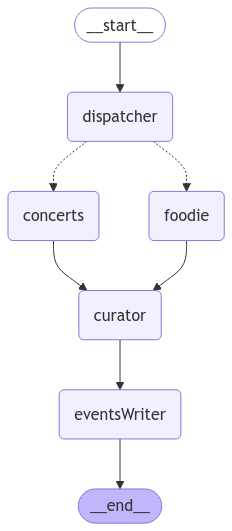

In [ ]:
print_graph(graph)

In [ ]:
graph_response = graph.invoke(
    dict(user_persona=jane_persona, agentsToInvoke = workerAgentsList, available_events = available_events), config=graph_config)

['foodie', 'concerts']
concert Nodes recs:  Based on your budget range of $20-50 and the available events, here are three recommended music events that fit within your budget and offer a diverse experience:

1. **Shannon and the Clams Concert**
   - **Date & Time:** October 19, 2024, 8:00 PM - 11:00 PM
   - **Location:** Fox Theater, 1807 Telegraph Ave, Oakland, CA 94612
   - **Description:** Enjoy a unique blend of retro rock ‘n’ roll, garage punk, and soulful vibes with this Oakland-based band. Known for their unforgettable shows, Shannon and the Clams offer a lively and engaging performance.
   - **Budget:** $50

2. **Royel Otis Concert**
   - **Date & Time:** October 18, 2024, 8:00 PM - 11:00 PM
   - **Location:** Fox Theater, 1807 Telegraph Ave, Oakland, CA 94612
   - **Description:** Experience the Australian indie duo, Royel Otis, live as they perform their debut album, PRITTS & PRATTS. This event is a great opportunity to enjoy indie music and take a break from the usual routin

# Using Gradio

In [ ]:
%%capture --no-stderr
%pip install --no-cache-dir gradio

In [ ]:
import gradio as gr
from typing import List, Dict
from datetime import datetime
import pandas as pd
from pydantic import BaseModel, Field

# Assuming all the necessary classes and functions from your code are already defined
# (UserPersona, EventData, ReflectionState, dispatcherAgentNode, foodieNode, concertNode, etc.)

# Load the datasets
cal_events = pd.read_csv('/content/drive/MyDrive/student-2024-fall-ucal/Databases/cal_events.csv')
user_persona = pd.read_csv('/content/drive/MyDrive/student-2024-fall-ucal/Databases/user_persona.csv')

# Initialize the matcher
matcher = CalendarMatcher(cal_events)

def foodieNode(state: ReflectionState, config: RunnableConfig) -> ReflectionState:
    """
    This node is responsible for taking in events and fields from a userPersona to generate specific event recommendations for food
    """
    agent = config["configurable"]["agents"]["foodie"]
    userPersona = state.user_persona

    if state.feedback != "":
        print("Reviewing feedback...")
        prompt = dict(
            favoriteCuisines = userPersona.favoriteCuisines,
            foodie_budget = userPersona.foodie_budget,
            event_data = state.available_events,
            feedback = state.feedback,
            message_history = state.messageHistory
        )
    else:
        print("Prompting agent for foodie event recommendations")
        prompt = dict(
            favoriteCuisines = userPersona.favoriteCuisines,
            foodie_budget = userPersona.foodie_budget,
            event_data = state.available_events,
            feedback = state.feedback,
            message_history = state.messageHistory
        )

    response = agent.invoke(prompt)
    print(response.content)
    state.messageHistory.append(response.content)
    print("foodie recommendations: ", response.content)
    return state

# Function to process user input and generate recommendations
def process_input(message: str, history: List[List[str]]) -> str:
    # For simplicity, we'll use Jane Doe's persona
    jane_doe_data = next((item for item in json_user_data if item['Name'] == 'Jane Doe'), None)
    jane_persona = deserialize_user_persona(jane_doe_data)

    # Get available events
    availability = CalendarAvailability.from_calendar_data("student123", sample_calendar_data1)
    available_events = matcher.find_available_events(availability)

    # Initialize state
    state = ReflectionState(
        user_persona=jane_persona,
        agentsToInvoke=[],
        available_events=available_events,
        messageHistory=history,
        feedback=message
    )

    # Run the dispatcher agent
    state = dispatcherAgentNode(state, {"configurable": {"agents": {"dispatcher": dispatcher_agent}}})

    # Run the appropriate worker agents
    for agent in state.agentsToInvoke:
        if agent == "foodie":
            state = foodieNode(state, {"configurable": {"agents": {"foodie": foodie_agent}}})
        elif agent == "concerts":
            state = concertNode(state, {"configurable": {"agents": {"concerts": concert_agent}}})

    # Return the last message in the message history
    return state.messageHistory[-1]

# Create the Gradio interface
iface = gr.ChatInterface(
    process_input,
    title="UC Berkeley Event Recommender",
    description="Ask for event recommendations or provide feedback on previous suggestions.",
    examples=[
        "What food events do you recommend?",
        "Any concert recommendations?",
        "I prefer cheaper events.",
        "Can you suggest more diverse options?"
    ],
)

# Launch the interface
iface.launch(debug=True)